In [1]:
import matplotlib.pyplot as plt
import geopandas
import shapely.wkt
import pandas as pd
import csv
import re

In [2]:
states = geopandas.read_file('data/bound_p.shx')

df = pd.read_csv ('data/faa_artcc_polygons.csv')
df2 = pd.read_csv ('data/spaceports.csv')
df3 = pd.read_csv ('data/AirportData_Clean_20210629_Geocoded.csv')

P = [shapely.wkt.loads(h) for h in df['boundary']]

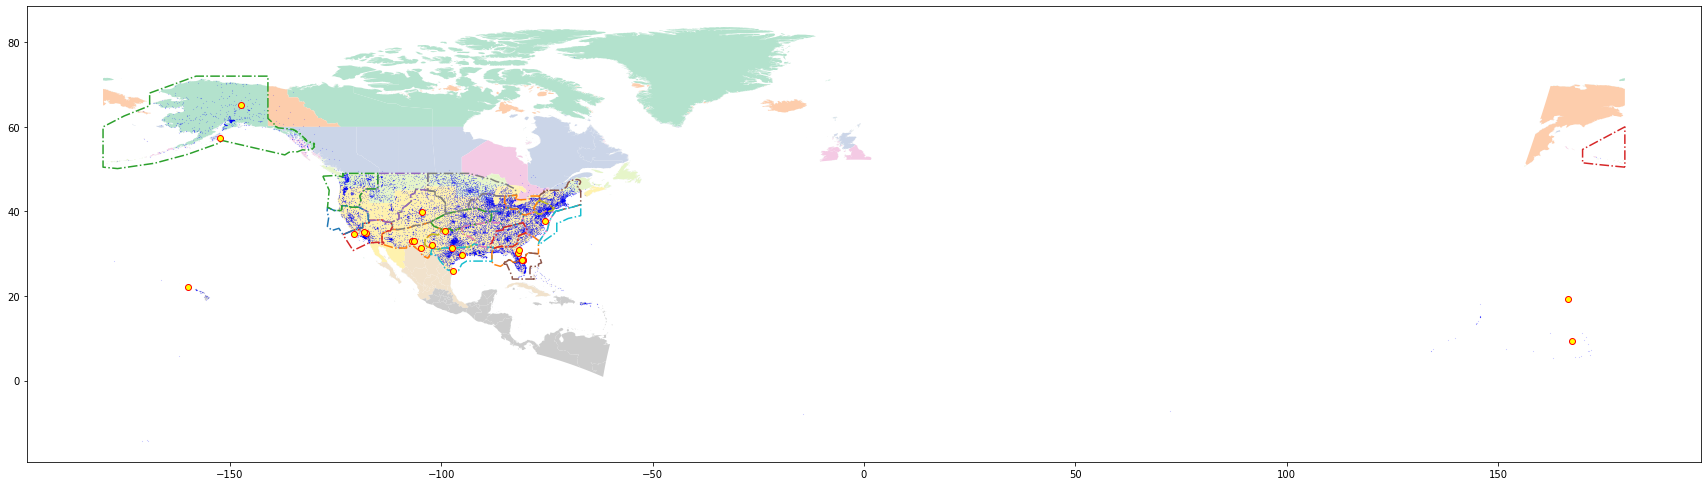

In [3]:
states.plot(cmap='Pastel2', figsize=(30, 10))

plt.plot(df3['longitude_degrees'], df3['latitude_degrees'], marker="o", markeredgecolor="blue", markerfacecolor="black", markersize=.07, linestyle="None")

for item in P:
    x,y = item.exterior.xy
    plt.plot(x,y, linestyle="dashdot")

plt.plot(df2['LONGITUDE'], df2['LATITUDE'], marker="o", markeredgecolor="red", markerfacecolor="yellow", linestyle="None")

In [4]:
msg = 'NAV ILS RWY 27 LOC/GP OUT OF SERVICE'

In [5]:
abbrev_dict = {}

with open('data/Contractions (Clean).csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    abbrev_dict = {rows[0]:rows[1] for rows in reader}
    
def expandNotam(msg):
    new_string = re.sub(r"[^a-zA-Z0-9]"," ",str(msg))
    new_msg = ''
    for wrd in new_string.split():        
        try:
            new_msg = new_msg + ' ' + abbrev_dict[wrd]
        except:
            new_msg = new_msg + ' ' + wrd
    return new_msg.lower().strip()

In [6]:
expandNotam(msg)

'navigation instrument landing system runway 27 locally glide path out of service'

In [7]:
df4 = pd.read_csv('data/notams.csv', on_bad_lines='skip', encoding='utf-16')

/var/folders/cj/0ysqssvs12l97gk55z1vr2mdk43v6z/T/ipykernel_8432/3088472792.py:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('data/notams.csv', on_bad_lines='skip', encoding='utf-16')


In [8]:
for x in df4['TEXT'].head(20):
    print(x)

AIRSPACE VOLK SOUTH MOA ACT 500FT UP TO BUT NOT INCLUDING FL180
AIRSPACE VOLK EAST MOA ACT 8000FT UP TO BUT NOT INCLUDING FL180
AIRSPACE FALLS 1 MOA ACT 500FT UP TO BUT NOT INCLUDING FL180
AIRSPACE FALLS 2 MOA ACT 500FT UP TO BUT NOT INCLUDING FL180
AIRSPACE VOLK WEST MOA ACT 100FT UP TO BUT NOT INCLUDING FL180
ILS SV 109.5 MHZ RWY 03 U/S
CYQY ILS 07 U/S
RWY 17/35 CLSD EXC XNG
AIRSPACE JACKAL MOA ACT 11000FT UP TO BUT NOT INCLUDING FL180
AIRSPACE JACKAL LOW MOA ACT 100FT-10999FT
AIRSPACE COLUMBUS 3 MOA ACT 8000FT UP TO BUT NOT INCLUDING FL180
AIRSPACE COLUMBUS 4 MOA ACT 10000FT UP TO BUT NOT INCLUDING FL180
AIRSPACE AR112L(E) ACT FL190-FL230
AIRSPACE AR112L(E) ACT FL190-FL230
AIRSPACE AR101(S) ACT FL260-FL290
AIRSPACE AR101(S) ACT FL260-FL290
AIRSPACE ABEL EAST MOA ACT 5000FT-12999FT
AIRSPACE AR20(SW) ACT FL240-FL280
OBST - CRANE IN AREA RADIUS 20M PSN 494110N0180622E.  HGT 30M AGL/283M AMSL. DAY MARKING
CYSB CRANE 1000 FT BEYOND THR 04 AND 1200 FT RIGHT RCL. 150 FT AGL 1293 MSL. NOT L

In [10]:
df4['TEXT'] = df4['TEXT'].apply(expandNotam)

In [11]:
for x in df4['TEXT'].head(20):
    print(x)

airspace volk south military operations area active 500ft up to but not including fl180
airspace volk east military operations area active 8000ft up to but not including fl180
airspace falls 1 military operations area active 500ft up to but not including fl180
airspace falls 2 military operations area active 500ft up to but not including fl180
airspace volk west military operations area active 100ft up to but not including fl180
instrument landing system sv 109 5 mhz runway 03 intensity unknown (weather reports only) south or southern latitude
cyqy instrument landing system 07 intensity unknown (weather reports only) south or southern latitude
runway 17 35 closed except crossing
airspace jackal military operations area active 11000ft up to but not including fl180
airspace jackal low military operations area active 100ft 10999ft
airspace columbus 3 military operations area active 8000ft up to but not including fl180
airspace columbus 4 military operations area active 10000ft up to but n

In [50]:
from sentence_transformers import SentenceTransformer, models
from torch import nn
import numpy as np

# Out-of-the-Box Model
#model = SentenceTransformer('bert-large-nli-mean-tokens')
model = SentenceTransformer('all-MiniLM-L6-v2')


subsample = df4['TEXT'].loc[np.random.choice(df4['TEXT'].index, 20000, replace=False)]

# Set max NOTAM length to 100 words and max features size to 100
#embedding_model = models.Transformer('bert-base-uncased', max_seq_length=100)
#pooling_model = models.Pooling(embedding_model.get_word_embedding_dimension())
#dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=100, activation_function=nn.Tanh())
#model = SentenceTransformer(modules=[embedding_model, pooling_model, dense_model])

# tokenize and build vocab
embeddings = model.encode(subsample.values)

In [ ]:
import pickle

df4.to_pickle("data/allData.pkl")

In [ ]:
import pandas as pd
df4 = pd.read_pickle("data/allData.pkl"")

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

SSE1 = []
x = range(2,30)

for i in x:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(embeddings)
    
    SSE_tmp = 0
    
    for indx, row in enumerate(embeddings):
        dist = cosine_distances([row],[kmeans.cluster_centers_[kmeans.labels_[indx]]])
        SSE_tmp = SSE_tmp + dist * dist
        
    SSE1.append(SSE_tmp)
    
SSE1 = np.asarray(SSE1, dtype = np.float64).reshape((-1))

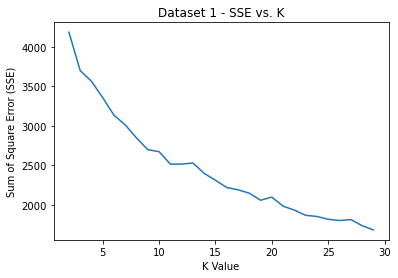

In [52]:
import matplotlib.pyplot as plt

plt.plot(x, SSE1)
plt.ylabel('Sum of Square Error (SSE)')
plt.xlabel('K Value')
plt.title("Dataset 1 - SSE vs. K")
plt.show()

For n_clusters = 5 The average silhouette_score is : 0.07545406
For n_clusters = 10 The average silhouette_score is : 0.10152172
For n_clusters = 15 The average silhouette_score is : 0.1272043
For n_clusters = 20 The average silhouette_score is : 0.1454794
For n_clusters = 25 The average silhouette_score is : 0.16342874
For n_clusters = 30 The average silhouette_score is : 0.1688258


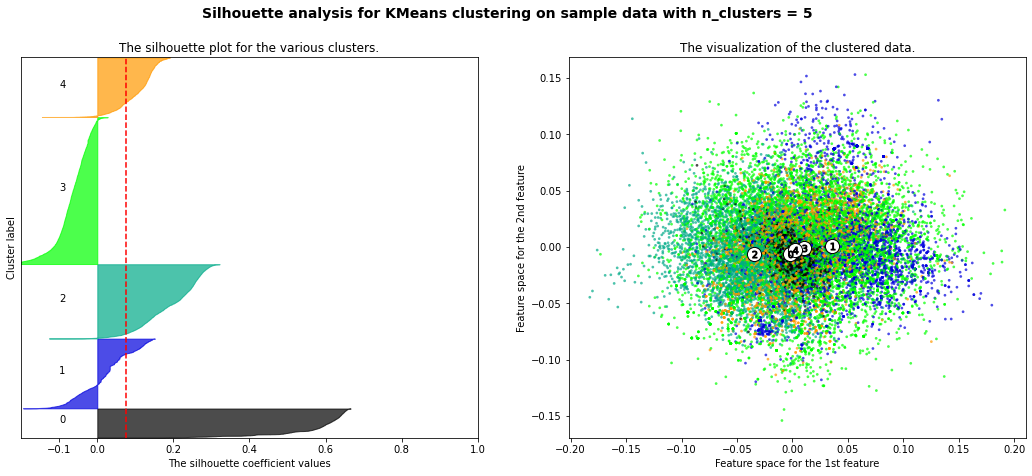

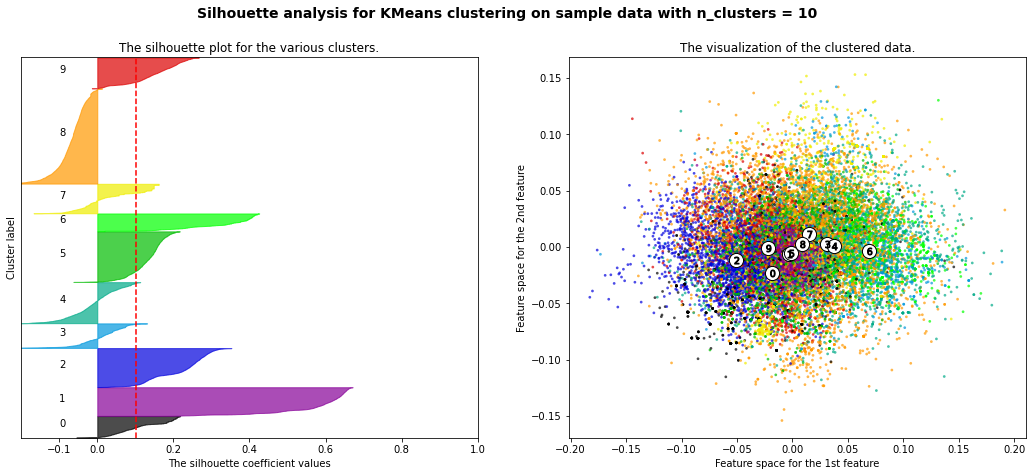

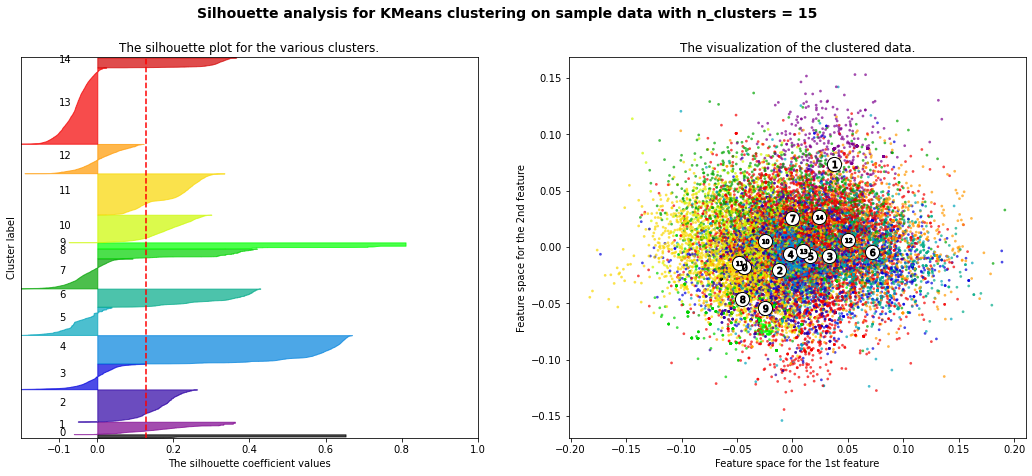

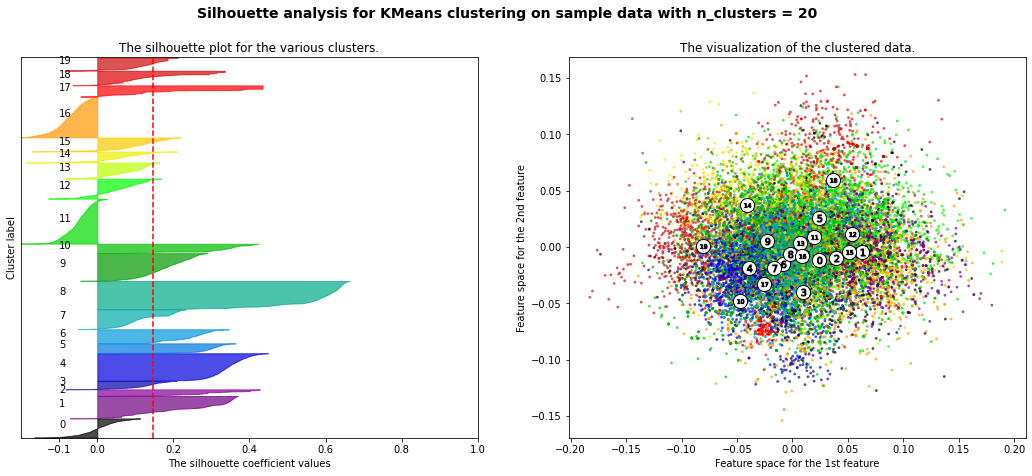

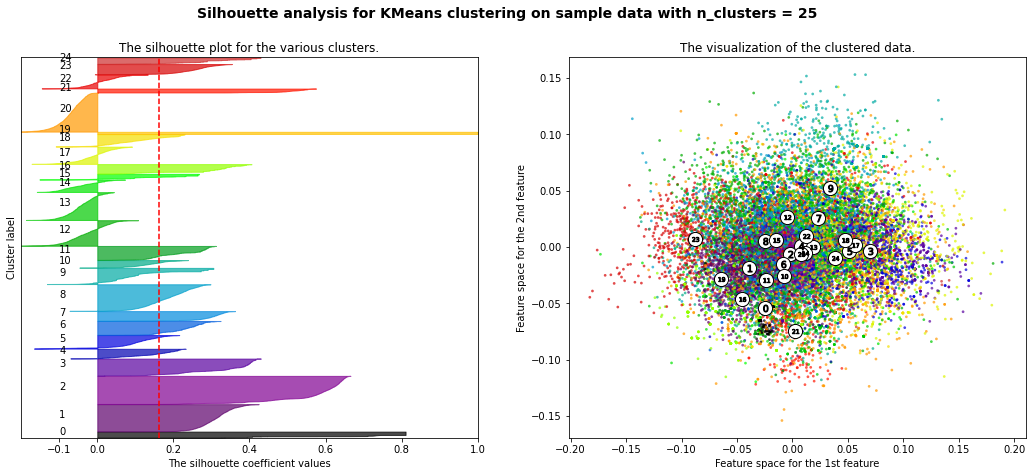

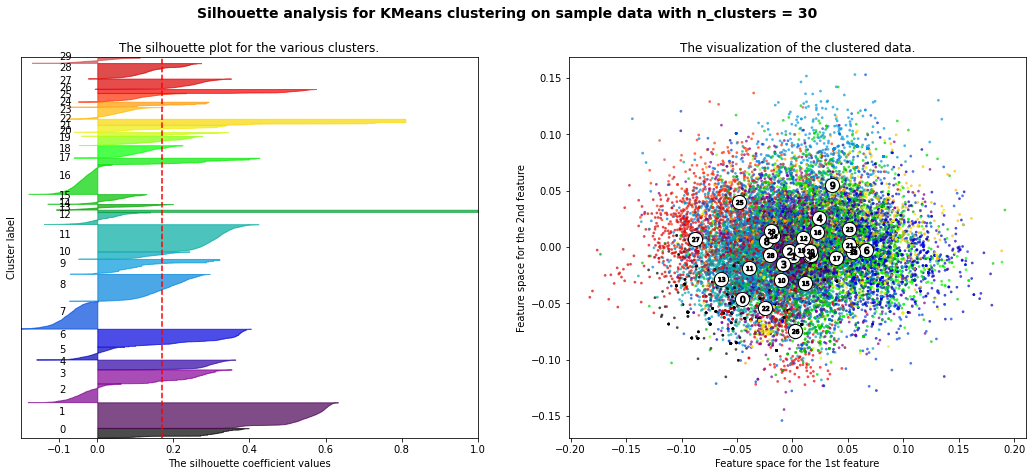

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = embeddings

range_n_clusters = [5, 10, 15, 20, 25, 30]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the cluster
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Compute silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate and sort the silhouette scores for samples in ith cluster
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # The 2nd Plot showing the clusters
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

In [78]:
#corpus = df4['TEXT'].values
corpus = df4['TEXT'].loc[np.random.choice(df4['TEXT'].index, 10000, replace=False)]

count_vect = CountVectorizer(stop_words=stopwords.words('english'), lowercase=True)
x_counts = count_vect.fit_transform(corpus)
x_counts.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [79]:
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)

In [80]:
dimension = 10
lda = LDA(n_components = dimension)
lda_array = lda.fit_transform(x_tfidf)

In [81]:
components = [lda.components_[i] for i in range(len(lda.components_))]
features = count_vect.get_feature_names()
important_words = [sorted(features, key = lambda x: components[j][features.index(x)], reverse = True)[:5] for j in range(len(components))]
important_words

/Users/brensikeg/opt/anaconda3/envs/daen690/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[['taxiway', 'runway', 'closed', 'aerodrome', 'temperature'],
 ['airspace', 'active', 'military', 'operations', 'area'],
 ['nan', 'absolute', 'temperature', 'notamc', 'active'],
 ['navigation', 'system', 'instrument', 'landing', 'runway'],
 ['ficon', 'observed', 'area', 'restricted', 'prct'],
 ['active', 'notamc', 'absolute', 'area', 'temperature'],
 ['control', 'information', 'flight', 'aeronautical', 'traffic'],
 ['global', 'positioning', 'monitoring', 'autonomous', 'integrity'],
 ['automated', 'service', 'active', 'broadcast', 'aid'],
 ['ausots', 'communication', 'absolute', 'temperature', 'flex']]